# STG 3

Simulate the parameterizations of the STG model shown in the original paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from seaborn import despine
from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import metric_utils
from neuroprobnum.utils import plot_utils as pltu

# Generator

In [4]:
from neuroprobnum.models.stg_model import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.stg_model import get_stg_model
from neuroprobnum.generator.generator_stg import DataGeneratorSTG

def get_panel_generator(panel, tmax, n_samples=100):
    """Get generator for panel"""
    network = get_stg_model(n_neurons=3, g_params=panel, y0from1n=False)
    
    gen = DataGeneratorSTG(
        y0=network.y0, t0=0.0, tmax=tmax*1e3, acc_same_ts=False,
        vidx=None, yidxs=np.arange(46), max_step=10, n_parallel=10,
        model=network, n_samples=n_samples,
        gen_det_sols=True, gen_acc_sols=True, 
        base_folder='data/examples_stg',
        return_vars=['ys', 'events']
    )
    
    gen.update_subfoldername(panel=panel)
    
    return gen

In [6]:
panel2tmax = {
    'a': 2.5,
    'b': 2.5,
    'c': 2.5,
    'd': 6,
    'e': 2.5,
}

gens = {}

panels = 'abcde'
for panel in panels:
    print(panel)
    gens[panel] = get_panel_generator(panel=panel, tmax=panel2tmax[panel])
    gens[panel].load_acc_sols_from_file()

a
Not acc sols file found!
b
Not acc sols file found!
c
Not acc sols file found!
d
Not acc sols file found!
e
Not acc sols file found!


## Test

  0%|          | 0/100 samples [00:00<?]

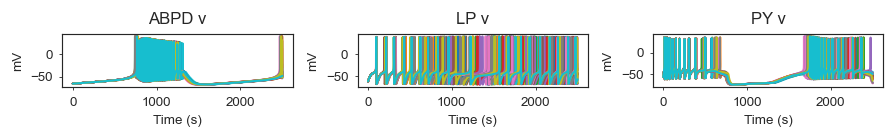

In [7]:
sol = gens['b'].gen_sol(method='RKDP', adaptive=1, step_param=1e-3, pert_method='conrad', plot=True)

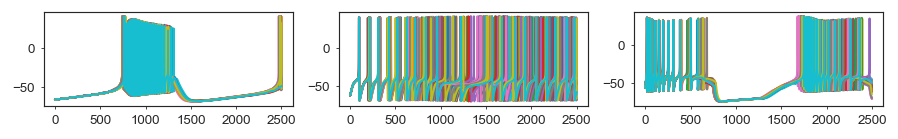

In [8]:
sol.plot(y_idxs=[0,13,26])

# Data

## Define Data

In [9]:
# pert_method, adaptive, methods, step_params
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.1]),
]

## Create data

In [10]:
for panel, gen in gens.items():
    
    print('----------------------------------------------------------')
    print(panel, ':', gen.subfoldername)
    print('----------------------------------------------------------')   
    
    for pert_method, adaptive, methods, step_params in solver_params:
        for step_param, method in itproduct(step_params, methods):
            data = gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, plot=False, allowgenerror=False,
                overwrite=False,
            )

----------------------------------------------------------
a : panel_a_tmax_2500.0
----------------------------------------------------------
             panel_a_tmax_2500.0/EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because file was not found.
No acc_sol found. Create reference solution!
----------------------------------------------------------
b : panel_b_tmax_2500.0
----------------------------------------------------------
             panel_b_tmax_2500.0/EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because file was not found.
No acc_sol found. Create reference solution!
----------------------------------------------------------
c : panel_c_tmax_2500.0
----------------------------------------------------------
             panel_c_tmax_2500.0/EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because file was not found.
No acc_sol found. Create reference solution!
----------------------------------------------------------
d : panel_d_tmax_6000.0
-----------------------------------

tcmalloc: large alloc 2208038912 bytes == 0x18d15e000 @ 


No acc_sol found. Create reference solution!


tcmalloc: large alloc 2208038912 bytes == 0x210b1e000 @ 
tcmalloc: large alloc 2208038912 bytes == 0x2944de000 @ 
tcmalloc: large alloc 2208038912 bytes == 0x18d15e000 @ 


----------------------------------------------------------
e : panel_e_tmax_2500.0
----------------------------------------------------------
             panel_e_tmax_2500.0/EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because file was not found.
No acc_sol found. Create reference solution!


## Load data

In [11]:
from neuroprobnum.generator.dataloader import DataLoader
import pandas as pd

df = pd.DataFrame()

for panel, gen in gens.items():
    panel_df = DataLoader(gen).load_data2dataframe(solver_params, MAEs=False, allowgenerror=True)
    metric_utils.add_det_nODEcalls(panel_df, T=gen.tmax-gen.t0)
    panel_df['panel'] = panel
    df = df.append(panel_df, ignore_index=True)
    
df.columns

tcmalloc: large alloc 2208038912 bytes == 0x1c3eca000 @ 


Index(['acc_events', 'acc_ts', 'acc_ys', 'adaptive', 'det_events',
       'det_nODEcalls', 'det_run_time', 'det_ts', 'det_ys', 'events', 'method',
       'nODEcalls', 'n_samples', 'pert_method', 'pert_param', 'run_times',
       'seed', 'step_param', 't0', 'tmax', 'ts', 'ys',
       'det_nODEcalls_per_time', 'panel'],
      dtype='object')

### Compute KDEs

In [12]:
vidxs = [0, 13, 26]
event_idx = 1
yidx = vidxs[event_idx]

In [13]:
from neuroprobnum.utils.metric_utils import compute_kde

df[['kde', 'kde_ts']] = None

for i, row in df.iterrows():
    kde_ts = np.linspace(row.t0, row.tmax, 2001)
    df.at[i, 'kde_ts'] = kde_ts
    
try:
    from joblib import Parallel, delayed
    df['kde'] = Parallel(n_jobs=np.maximum(len(df), 20))(delayed(compute_kde)(
        np.concatenate([e_list[event_idx] for e_list in row.events]), row.kde_ts, np.mean([len(e_list[event_idx]) for e_list in row.events])) for i, row in df.iterrows())
    
except ImportError:
    for i, row in df.iterrows():
        kde = compute_kde(X=np.concatenate([events[event_idx] for events in row.events]), kde_ts=row.kde_ts, scale=np.mean([len(e_list[event_idx]) for e_list in row.events]))
        df.at[i, 'kde'] = kde

# Plot

In [14]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs, plot_events, plot_kde

rows_per_mode = 4

def plot_row(axs, row, nraster=5):
    
    assert axs.size == rows_per_mode, axs.size

    plot_vs(ax=axs[0], ts=row.acc_ts, vs=row.acc_ys[:, yidx], c='k', lw=0.75)
    plot_vs(ax=axs[1], ts=row.det_ts, vs=row.det_ys[:, yidx], c='C1', lw=0.75)   
    plot_kde(ax=axs[2], kde_ts=row.kde_ts, kde=row.kde)
    plot_events(ax=axs[3], events=row.events[:nraster], event_idx=event_idx,
                event_traces={'det.': (row.det_events[event_idx], 'C1'), 'ref.': (row.acc_events[event_idx], 'k')}, lw=0.75)
    
    pltu.make_share_xlims(axs)
    for ax in axs[:-1]:
        ax.set_xlabel(None)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

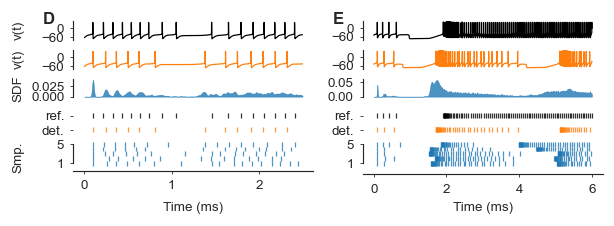

In [15]:
num_rows = 1
num_cols = 2

fig, axs = pltu.subplots(num_cols, rows_per_mode*num_rows, ysizerow=0.38, yoffsize=0.3, xsize='text', gridspec_kw=dict(
    height_ratios=([0.25]*(rows_per_mode-2) + [0.25, 0.85])*num_rows), squeeze=False)

despine()

for i, (_, row) in enumerate(df[(df.method == 'EE') & ((df.panel == 'b') | (df.panel == 'd'))].iterrows()):
    if i*rows_per_mode >= axs.size:
        break
    axs_set = axs[int(i/num_cols)*rows_per_mode:(int(i/num_cols)+1)*rows_per_mode, i%num_cols]
    plot_row(axs=axs_set, row=row)
    
for ax in axs[:, 1:].flat:
    ax.set_ylabel(None)

# Adjust spacing
mode_spacing = 0.085
plt.tight_layout(h_pad=-2.5 if num_rows > 1 else 0.3, rect=[0, (num_rows-1)*mode_spacing, 1, 1])
for i in range(num_rows):
    pltu.move_box(axs[i*rows_per_mode:(i+1)*rows_per_mode], dy=-mode_spacing*i)
    
pltu.set_labs(axs[np.arange(0, num_rows)*rows_per_mode, :], panel_nums=['D', 'E'], panel_num_space=4, panel_num_va='center', panel_num_y=1.1)
pltu.scale_ticks(axs, scale=1e-3, x=True, y=False)

fig.align_labels()

pltu.move_xaxis_outward(axs[:, -1], scale=2)

pltu.savefig("fig2d_e")
plt.show()

### Appendix figure

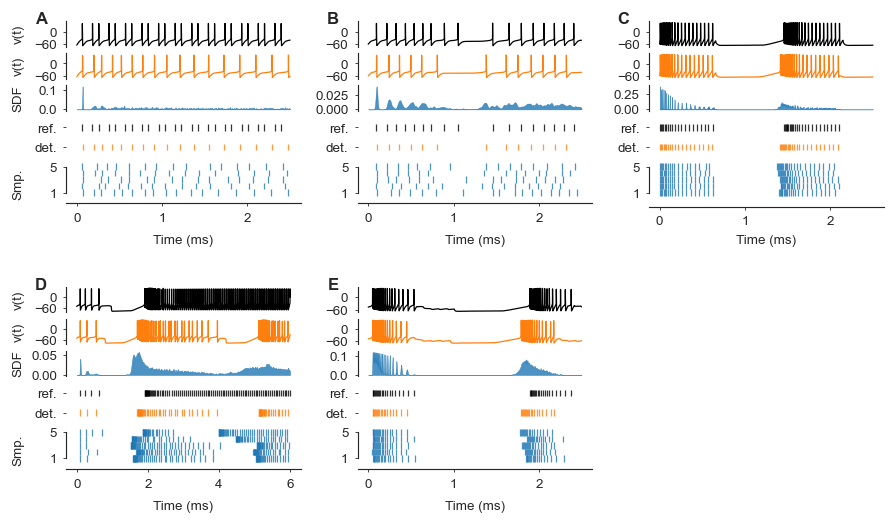

In [16]:
num_rows = 2
num_cols = 3

fig, axs = pltu.subplots(num_cols, rows_per_mode*num_rows, ysizerow=0.5, yoffsize=0.3, xsize='fullwidth', gridspec_kw=dict(
    height_ratios=([0.25]*(rows_per_mode-1) + [0.85])*num_rows), squeeze=False)

despine()

for i, (_, row) in enumerate(df.sort_values(['panel']).iterrows()):
    if i*rows_per_mode >= axs.size:
        break
        
    axs_set = axs[int(i/num_cols)*rows_per_mode:(int(i/num_cols)+1)*rows_per_mode, i%num_cols]
    plot_row(axs=axs_set, row=row)
    
for ax in axs[:, 1:].flat:
    ax.set_ylabel(None)
    
for ax in axs[rows_per_mode:, 2:].flat:
    ax.axis('off')
    
# Adjust spacing
mode_spacing = 0.15
plt.tight_layout(h_pad=-2.5 if num_rows > 1 else 0.3, rect=[0, (num_rows-1)*mode_spacing, 1, 1])

for i in range(num_rows):
    pltu.move_box(axs[i*rows_per_mode:(i+1)*rows_per_mode], dy=-mode_spacing*i)
    
pltu.set_labs(axs[np.arange(0, num_rows)*rows_per_mode, :].flatten()[:len(df)], panel_nums='auto', panel_num_space=4, panel_num_va='center', panel_num_y=1.1)
pltu.scale_ticks(axs, scale=1e-3, x=True, y=False)

fig.align_labels()

pltu.move_xaxis_outward(axs[:, -1], scale=2)

pltu.savefig("figS2")
plt.show()

# Text

In [17]:
for i, (_, row) in enumerate(df.sort_values(['panel']).iterrows()):
    print(row.panel)
    print('n_acc ='.ljust(15), len(row.acc_events[event_idx]))
    print('n_det ='.ljust(15), len(row.det_events[event_idx]))
    print('n_prob_mu ='.ljust(15), f"{np.mean([len(e_list[event_idx]) for e_list in row.events]):.1f}")
    print('n_prob_std ='.ljust(15), f"{np.std([len(e_list[event_idx]) for e_list in row.events], ddof=1):.1f}\n")

a
n_acc =         25
n_det =         17
n_prob_mu =     15.9
n_prob_std =    0.9

b
n_acc =         17
n_det =         13
n_prob_mu =     14.6
n_prob_std =    1.3

c
n_acc =         44
n_det =         42
n_prob_mu =     41.0
n_prob_std =    0.6

d
n_acc =         94
n_det =         67
n_prob_mu =     68.5
n_prob_std =    3.3

e
n_acc =         40
n_det =         36
n_prob_mu =     35.1
n_prob_std =    1.1

